# Imports

In [1]:
%reload_ext autoreload
%autoreload 2

from plots import (
    winrate,
    benchs,
    splits,
    methods,
    agg_metric,
    load_scores,
    # plot_perf_lines,
    color_mappings,
    rename_mappings,
    plot_perf_lines_v2,
    make_perf_table
    # markers
)
from utils import (
    dump_pickle,
    load_pickle
)
from scipy import stats
from copy import deepcopy
from generating_data.utils_for_notebooks import merge_methods
import pandas as pd
from IPython.display import display
import pickle
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import os
import torch
from datetime import datetime

# Functions

In [3]:
agg = 'leaderboard' # 'leaderboard', 'scenarios'
results = 'acc'# 'acc', 'rank'

style = {"alpha":1, "markersize":3, "markeredgewidth":1, "elinewidth":1, "capsize":3, "linestyle":''}

# def merge_methods(table_avg, table_avg_reproduced):
#     for bench in table_avg.keys():
#         for split in table_avg[bench].keys():
#             for method in table_avg_reproduced[bench][split].keys():
#                 if method not in table_avg[bench][split].keys():
#                     table_avg[bench][split][method] = table_avg_reproduced[bench][split][method]
#     return table_avg


def check_order(data, df_raw_lb, df_raw_mmlu, idx=None):
    dates_list = []
    for model_name in data['models']:
        if model_name in df_raw_lb.keys():
            df = df_lb_raw
            # [0][:10]
        else:
            assert model_name in df_raw_mmlu.keys()
            df = df_raw_mmlu
        date = df[model_name]['harness_gsm8k_5']['dates'][0][:10]
        dates_list.append(datetime.strptime(date, '%Y_%m_%d'))
        # break
    dates = np.array(dates_list)
    # print(dates)
    order = np.argsort(dates)[::-1]
    print("Newest first:")
    print(order)
    print(f"{order[0]}:", dates[order[0]])
    print(f"{order[-1]}:", dates[order[-1]])
    if idx is not None:
        print(f"{idx}:", dates[idx])


# Key result

In [3]:
# Load table_avg from pickle file
with open('/home/<PATH>17/github/efficbench/results/table_avg.pickle', 'rb') as handle:
    table_avg = pickle.load(handle)
with open('/home/<PATH>17/github/efficbench/results/table_std.pickle', 'rb') as handle:
    table_std = pickle.load(handle)
with open('/home/<PATH>17/github/efficbench/results/model_perf.pickle', 'rb') as handle:
    model_perf = pickle.load(handle)

# Load table_avg from pickle file
with open('/home/<PATH>17/github/efficbench/results/table_avg_original.pickle', 'rb') as handle:
    table_avg_original = pickle.load(handle)
with open('/home/<PATH>17/github/efficbench/results/table_std_original.pickle', 'rb') as handle:
    table_std_original = pickle.load(handle)
with open('/home/<PATH>17/github/efficbench/results/model_perf_original.pickle', 'rb') as handle:
    model_perf_original = pickle.load(handle)

table_avg = merge_methods(table_avg, table_avg_original)
table_std = merge_methods(table_std, table_std_original)
model_perf = merge_methods(model_perf, model_perf_original)

if results == 'acc': ylim = (0,.1)
elif results == 'rank':
    if agg_metric == 'std': ylim = (0,.1)
    else: ylim = (.5,1)
else: raise NotImplementedError


cur_methods = table_avg["mmlu_fields"]["iid"].keys()
cur_methods = [method for method in cur_methods if method not in ['random_pirt', 'anchor_pirt', 'random_cirt', 'anchor_cirt', "anchor-irt_cirt", "anchor-irt_pirt"]]
cur_methods = [method for method in cur_methods if method not in ["anchor_gpirt", "random_gpirt", "anchor_naive", "random_naive", "anchor-irt_naive"]]


DEBUG: skipping noniid for now


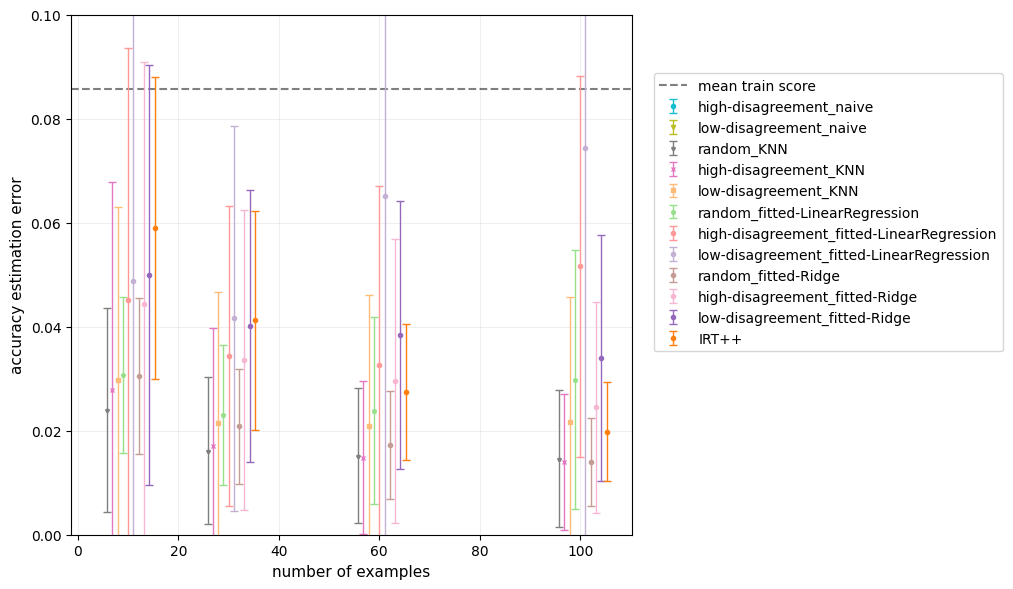

In [4]:
plt.figure(figsize=(16, 6))
# ylim = (0,0.4)
ylim = (0, 0.1)
bench='mmlu_fields'
# methods = table_avg["mmlu_fields"]["iid"].keys()
# methods = [method for method in methods if method not in ['random_pirt', 'anchor_pirt', 'random_cirt', 'anchor_cirt', "anchor-irt_cirt", "anchor-irt_pirt"]]
# methods = [method for method in methods if method not in ["anchor_gpirt", "random_gpirt", "anchor_naive", "random_naive", "anchor-irt_naive"]]
# Iterate over your benchmarks
for i, split in enumerate(splits[bench]):  # Replace `benchmarks` with your list of benchmarks

    # print(table_avg[bench][split])

    if split == 'noniid':
        print("DEBUG: skipping noniid for now")
        continue
    # Plot on the ith subplot
    plt.subplot(1, 2, i+1)
    if results == 'rank': ylabel='Spearman correlation \nfor LLMs ranking'
    else: ylabel='accuracy estimation error'

    # if split == 'noniid':
    #     cur_methods = [method for method in methods if method not in ['mean_train_score']] # [ADD][new estimator]
    # else:
    #     cur_methods = methods

    plot_perf_lines_v2(
        table_avg[bench][split],
        table_std[bench][split],
        methods=cur_methods,
        title='',
        xlabel='number of examples',
        ylabel=ylabel,
        ylim=ylim,
        legend=i==0,
        error_bar=True,
        show_ylabel=split=='iid',
        ncols=1,
        posic=(1.35, .9)
    )
    plt.tight_layout()
plt.savefig(f'plots/mmlu_performance_specialized_models_{results}.png', bbox_inches='tight', dpi=400, transparent=True)
plt.show()

In [20]:

bench='mmlu_fields'

cur_methods_for_table = table_avg["mmlu_fields"]["iid"].keys()

# Iterate over your benchmarks
for i, split in enumerate(splits[bench]):  # Replace `benchmarks` with your list of benchmarks

    if split == 'noniid':
        print("DEBUG: skipping noniid for now")
        continue

    df = make_perf_table(
        table_avg[bench][split],
        table_std[bench][split],
        methods=cur_methods_for_table,
    )
    print(df.keys())

    pd.set_option('display.max_rows', 1000)
    pd.set_option('display.max_columns', 1000)
    for num_samples in df.keys():
        print("#anchor_points:", num_samples)
        # Reorder columns to put guiding models, PDS type, and stratified first
        cols = df[num_samples].columns.tolist()
        first_cols = ['#guiding_models', 'PDS type', 'stratified']
        other_cols = [col for col in cols if col not in first_cols]
        df[num_samples] = df[num_samples][first_cols + other_cols]

        # Replace all values in #guiding_models column with 382
        df[num_samples].loc[df[num_samples]['#guiding_models'] == 'all', '#guiding_models'] = 382

        # Sort rows by #guiding_models
        df[num_samples] = df[num_samples].sort_values(['PDS type', 'stratified', '#guiding_models'])

        display(df[num_samples])
# plt.savefig(f'plots/mmlu_performance_specialized_models_{results}.png', bbox_inches='tight', dpi=400, transparent=True)
# plt.show()
df[100].to_csv('df_100.csv')

dict_keys([10, 30, 60, 100])
#anchor_points: 10


,#guiding_models,PDS type,stratified,naive,pirt,cirt,gpirt,KNN,MLP3_e700_lr0.001,Ridge_10,Lasso_e-4,RandomForestRegressor_100,GradientBoostingRegressor_200,mean_train_score,perfect_knn
high-disagreement@100+nonstratified,100,highest,False,0.194877,0.099421,0.099638,0.115405,0.024205,0.039797,0.039354,0.039205,0.035271,0.038325,NaN,NaN
random,NaN,NaN,NaN,0.141658,0.081075,0.081173,0.078394,0.025194,0.030299,0.034111,0.032614,0.026989,0.026175,NaN,NaN
anchor,NaN,NaN,NaN,0.049662,0.036719,0.03666,0.032698,0.021477,0.025124,0.022599,0.020775,0.01802,0.018795,NaN,NaN
anchor-irt,NaN,NaN,NaN,0.111312,0.055164,0.055464,0.062261,0.025119,0.02323,0.030637,0.028923,0.024155,0.024584,NaN,NaN
-,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.088467,0.001114


#anchor_points: 30


,#guiding_models,PDS type,stratified,naive,pirt,cirt,gpirt,KNN,MLP3_e700_lr0.001,Ridge_10,Lasso_e-4,RandomForestRegressor_100,GradientBoostingRegressor_200,mean_train_score,perfect_knn
high-disagreement@100+nonstratified,100,highest,False,0.219987,0.091415,0.091631,0.137217,0.017886,0.042833,0.031535,0.033536,0.0177,0.015526,NaN,NaN
random,NaN,NaN,NaN,0.08609,0.062044,0.062129,0.058809,0.02429,0.040864,0.023489,0.022951,0.020378,0.020127,NaN,NaN
anchor,NaN,NaN,NaN,0.038216,0.035839,0.035884,0.027454,0.019579,0.03019,0.01767,0.016546,0.015926,0.017333,NaN,NaN
anchor-irt,NaN,NaN,NaN,0.071807,0.04318,0.043239,0.042213,0.021865,0.038895,0.021549,0.020956,0.016767,0.016243,NaN,NaN
-,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.088467,0.001114


#anchor_points: 60


,#guiding_models,PDS type,stratified,naive,pirt,cirt,gpirt,KNN,MLP3_e700_lr0.001,Ridge_10,Lasso_e-4,RandomForestRegressor_100,GradientBoostingRegressor_200,mean_train_score,perfect_knn
high-disagreement@100+nonstratified,100,highest,False,0.195956,0.046853,0.046796,0.124598,0.020774,0.04279,0.025244,0.02542,0.017313,0.016135,NaN,NaN
random,NaN,NaN,NaN,0.04796,0.042053,0.041835,0.034695,0.023124,0.042871,0.019548,0.019083,0.016079,0.015673,NaN,NaN
anchor,NaN,NaN,NaN,0.029532,0.02896,0.028422,0.022916,0.016485,0.033464,0.015947,0.014736,0.013711,0.013702,NaN,NaN
anchor-irt,NaN,NaN,NaN,0.04701,0.033044,0.032864,0.035618,0.019874,0.038152,0.018796,0.01844,0.014483,0.014312,NaN,NaN
-,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.088467,0.001114


#anchor_points: 100


,#guiding_models,PDS type,stratified,naive,pirt,cirt,gpirt,KNN,MLP3_e700_lr0.001,Ridge_10,Lasso_e-4,RandomForestRegressor_100,GradientBoostingRegressor_200,mean_train_score,perfect_knn
high-disagreement@100+nonstratified,100,highest,False,0.201848,0.024956,0.024035,0.1462,0.024694,0.035234,0.019022,0.020459,0.017526,0.01916,NaN,NaN
random,NaN,NaN,NaN,0.038444,0.031683,0.030587,0.025946,0.022208,0.042593,0.015764,0.01554,0.014839,0.015513,NaN,NaN
anchor,NaN,NaN,NaN,0.023469,0.030227,0.027838,0.018035,0.020226,0.028714,0.016174,0.015669,0.014065,0.013307,NaN,NaN
anchor-irt,NaN,NaN,NaN,0.034843,0.030815,0.029594,0.029111,0.020717,0.041782,0.014998,0.015313,0.013231,0.013327,NaN,NaN
-,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.088467,0.001114


DEBUG: skipping noniid for now


In [22]:

bench='mmlu_fields'

cur_methods_for_table = table_avg["mmlu_fields"]["iid"].keys()

# Iterate over your benchmarks
for i, split in enumerate(splits[bench]):  # Replace `benchmarks` with your list of benchmarks

    if split == 'noniid':
        print("DEBUG: skipping noniid for now")
        continue

    df = make_perf_table(
        table_avg[bench][split],
        table_std[bench][split],
        methods=cur_methods_for_table,
    )
    print(df.keys())

    pd.set_option('display.max_rows', 1000)
    pd.set_option('display.max_columns', 1000)
    for num_samples in df.keys():
        print("#anchor_points:", num_samples)
        # Reorder columns to put guiding models, PDS type, and stratified first
        cols = df[num_samples].columns.tolist()
        first_cols = ['#guiding_models', 'PDS type', 'stratified']
        other_cols = [col for col in cols if col not in first_cols]
        df[num_samples] = df[num_samples][first_cols + other_cols]

        # Replace all values in #guiding_models column with 382
        df[num_samples].loc[df[num_samples]['#guiding_models'] == 'all', '#guiding_models'] = 382

        # Sort rows by #guiding_models
        df[num_samples] = df[num_samples].sort_values(['PDS type', 'stratified', '#guiding_models'])

        display(df[num_samples])
# plt.savefig(f'plots/mmlu_performance_specialized_models_{results}.png', bbox_inches='tight', dpi=400, transparent=True)
# plt.show()
df[100].to_csv('df_100.csv')

dict_keys([10, 30, 60, 100])
#anchor_points: 10


,#guiding_models,PDS type,stratified,naive,pirt,cirt,gpirt,KNN,MLP3_e700_lr0.001,Ridge_10,Lasso_e-4,RandomForestRegressor_100,GradientBoostingRegressor_200,mean_train_score,perfect_knn
high-disagreement@100+nonstratified,100,highest,False,0.523647,0.627928,0.627928,0.613722,0.957034,0.853821,0.91196,0.919511,0.897191,0.879553,NaN,NaN
random,NaN,NaN,NaN,0.58535,0.522186,0.513656,0.534403,0.93424,0.922138,0.919088,0.918695,0.936364,0.935307,NaN,NaN
anchor,NaN,NaN,NaN,0.915806,0.905994,0.90645,0.912691,0.970785,0.926699,0.964754,0.964573,0.969012,0.967019,NaN,NaN
anchor-irt,NaN,NaN,NaN,0.73963,0.793784,0.795783,0.799366,0.946822,0.957777,0.94334,0.941649,0.952854,0.950529,NaN,NaN
-,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.999849


#anchor_points: 30


,#guiding_models,PDS type,stratified,naive,pirt,cirt,gpirt,KNN,MLP3_e700_lr0.001,Ridge_10,Lasso_e-4,RandomForestRegressor_100,GradientBoostingRegressor_200,mean_train_score,perfect_knn
high-disagreement@100+nonstratified,100,highest,False,0.64546,0.652371,0.651918,0.680157,0.976591,0.840018,0.943069,0.922682,0.98067,0.986288,NaN,NaN
random,NaN,NaN,NaN,0.736837,0.707544,0.707454,0.745812,0.963226,0.849381,0.957838,0.953428,0.967532,0.968016,NaN,NaN
anchor,NaN,NaN,NaN,0.959988,0.905101,0.905433,0.947905,0.971302,0.900453,0.979795,0.978013,0.980036,0.975748,NaN,NaN
anchor-irt,NaN,NaN,NaN,0.869354,0.885905,0.88518,0.908679,0.957363,0.867986,0.966113,0.966173,0.978345,0.980066,NaN,NaN
-,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.999849


#anchor_points: 60


,#guiding_models,PDS type,stratified,naive,pirt,cirt,gpirt,KNN,MLP3_e700_lr0.001,Ridge_10,Lasso_e-4,RandomForestRegressor_100,GradientBoostingRegressor_200,mean_train_score,perfect_knn
high-disagreement@100+nonstratified,100,highest,False,0.695692,0.848535,0.844005,0.806554,0.980102,0.891,0.956811,0.950166,0.969043,0.982694,NaN,NaN
random,NaN,NaN,NaN,0.892932,0.894162,0.889541,0.906908,0.97471,0.877982,0.969888,0.967804,0.978496,0.976261,NaN,NaN
anchor,NaN,NaN,NaN,0.967275,0.937737,0.938643,0.963409,0.982851,0.88662,0.980217,0.980368,0.984265,0.984567,NaN,NaN
anchor-irt,NaN,NaN,NaN,0.898781,0.925511,0.925209,0.921222,0.975404,0.866928,0.976412,0.975143,0.979976,0.981335,NaN,NaN
-,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.999849


#anchor_points: 100


,#guiding_models,PDS type,stratified,naive,pirt,cirt,gpirt,KNN,MLP3_e700_lr0.001,Ridge_10,Lasso_e-4,RandomForestRegressor_100,GradientBoostingRegressor_200,mean_train_score,perfect_knn
high-disagreement@100+nonstratified,100,highest,False,0.740503,0.945032,0.948958,0.838719,0.968056,0.923769,0.977348,0.9701,0.981969,0.971036,NaN,NaN
random,NaN,NaN,NaN,0.92059,0.953299,0.949947,0.955474,0.974709,0.844548,0.981033,0.980852,0.982332,0.981003,NaN,NaN
anchor,NaN,NaN,NaN,0.970553,0.954032,0.955029,0.97312,0.976553,0.929417,0.978587,0.980761,0.982905,0.984808,NaN,NaN
anchor-irt,NaN,NaN,NaN,0.944358,0.941367,0.941005,0.950429,0.973646,0.836937,0.983177,0.983419,0.986107,0.984989,NaN,NaN
-,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.999849


DEBUG: skipping noniid for now


### Table for HELM

In [8]:
table_avg = table_avg_original
table_std = table_std_original

bench='helm_lite'

cur_methods_for_table = table_avg["helm_lite"]["iid"].keys()

# Iterate over your benchmarks
for i, split in enumerate(splits[bench]):  # Replace `benchmarks` with your list of benchmarks

    # if split == 'noniid':
    #     print("DEBUG: skipping noniid for now")
    #     continue

    df = make_perf_table(
        table_avg[bench][split],
        table_std[bench][split],
        methods=cur_methods_for_table,
    )
    print(df.keys())

    pd.set_option('display.max_rows', 1000)
    pd.set_option('display.max_columns', 1000)
    for num_samples in df.keys():
        print("#anchor_points:", num_samples)
        # Reorder columns to put guiding models, PDS type, and stratified first
        cols = df[num_samples].columns.tolist()
        first_cols = ['#guiding_models', 'PDS type', 'stratified']
        other_cols = [col for col in cols if col not in first_cols]
        df[num_samples] = df[num_samples][first_cols + other_cols]

        # Replace all values in #guiding_models column with 382
        df[num_samples].loc[df[num_samples]['#guiding_models'] == 'all', '#guiding_models'] = 382

        # Sort rows by #guiding_models
        df[num_samples] = df[num_samples].sort_values(['PDS type', 'stratified', '#guiding_models'])

        display(df[num_samples])
# plt.savefig(f'plots/mmlu_performance_specialized_models_{results}.png', bbox_inches='tight', dpi=400, transparent=True)
# plt.show()
df[100].to_csv('df_100.csv')

dict_keys([10, 30, 60, 100])
#anchor_points: 10


,#guiding_models,PDS type,stratified,naive,pirt,cirt,gpirt
random,NaN,NaN,NaN,0.029971,0.025401,0.027876,0.025090
anchor,NaN,NaN,NaN,0.021993,0.032915,0.033968,0.027799
anchor-irt,NaN,NaN,NaN,0.030917,0.029391,0.030127,0.027194


#anchor_points: 30


,#guiding_models,PDS type,stratified,naive,pirt,cirt,gpirt
random,NaN,NaN,NaN,0.017082,0.014522,0.019993,0.013853
anchor,NaN,NaN,NaN,0.014522,0.016511,0.016136,0.012592
anchor-irt,NaN,NaN,NaN,0.018157,0.015415,0.020306,0.015304


#anchor_points: 60


,#guiding_models,PDS type,stratified,naive,pirt,cirt,gpirt
random,NaN,NaN,NaN,0.010228,0.009177,0.014913,0.009133
anchor,NaN,NaN,NaN,0.011452,0.011288,0.012616,0.009192
anchor-irt,NaN,NaN,NaN,0.011501,0.010328,0.015743,0.009541


#anchor_points: 100


,#guiding_models,PDS type,stratified,naive,pirt,cirt,gpirt
random,NaN,NaN,NaN,0.009998,0.008164,0.013461,0.007837
anchor,NaN,NaN,NaN,0.009985,0.009276,0.009155,0.007681
anchor-irt,NaN,NaN,NaN,0.008897,0.008499,0.012911,0.007941


dict_keys([10, 30, 60, 100])
#anchor_points: 10


,#guiding_models,PDS type,stratified,naive,pirt,cirt,gpirt
random,NaN,NaN,NaN,0.029971,0.024222,0.029300,0.024229
anchor,NaN,NaN,NaN,0.020108,0.030407,0.031978,0.025723
anchor-irt,NaN,NaN,NaN,0.024601,0.023806,0.030165,0.022345


#anchor_points: 30


,#guiding_models,PDS type,stratified,naive,pirt,cirt,gpirt
random,NaN,NaN,NaN,0.017082,0.013598,0.020539,0.013229
anchor,NaN,NaN,NaN,0.012897,0.016425,0.020442,0.013107
anchor-irt,NaN,NaN,NaN,0.015678,0.013848,0.017770,0.014468


#anchor_points: 60


,#guiding_models,PDS type,stratified,naive,pirt,cirt,gpirt
random,NaN,NaN,NaN,0.010228,0.009616,0.017497,0.010017
anchor,NaN,NaN,NaN,0.009904,0.012738,0.015205,0.009827
anchor-irt,NaN,NaN,NaN,0.011259,0.009704,0.015451,0.010906


#anchor_points: 100


,#guiding_models,PDS type,stratified,naive,pirt,cirt,gpirt
random,NaN,NaN,NaN,0.009998,0.009001,0.014980,0.008797
anchor,NaN,NaN,NaN,0.008362,0.012743,0.013332,0.008044
anchor-irt,NaN,NaN,NaN,0.008598,0.010043,0.013380,0.008318


## Analyze PDS distribution

In [23]:

def plot_pds_distributions(key, pds_scores_folder, plot_each=False):
    all_disagreement_scores = []
    for file in os.listdir(pds_scores_folder):
        # key = 'n_guiding=all'

        if key in file:
            sub = file.split('_sub=')[1].split('_n_guiding=')[0]
            disagreement_scores = torch.load(os.path.join(pds_scores_folder, file), weights_only=False)
            all_disagreement_scores.append(disagreement_scores)
            # print(file)
            # print(sub)
            # print(disagreement_scores.shape)

            # Plot histogram and store bin counts and edges
            if plot_each:
                plt.figure(figsize=(10, 6))
                counts, edges, _ = plt.hist(disagreement_scores, bins=30, edgecolor='black')
                plt.title(f'Distribution of PDS Scores for {sub} with {key}')
                plt.xlabel('PDS Score')
                plt.ylabel('Frequency')
                plt.grid(True, alpha=0.3)
                plt.show()
            else:
                counts, edges = np.histogram(disagreement_scores, bins=30)

            # Store the histogram data for later averaging
            if not hasattr(plot_pds_distributions, 'hist_data'):
                plot_pds_distributions.hist_data = []
            plot_pds_distributions.hist_data.append((counts, edges))

            # If this is the last file, plot the average histogram
            files_with_key = [f for f in os.listdir(pds_scores_folder) if key in f]
            if file == files_with_key[-1]:
                plt.figure(figsize=(10, 6))
                # Calculate and plot average histogram
                avg_counts = np.mean([data[0] for data in plot_pds_distributions.hist_data], axis=0)
                bin_centers = (edges[:-1] + edges[1:]) / 2
                plt.bar(bin_centers, avg_counts, width=np.diff(edges), edgecolor='black', alpha=0.5, label='Average')
                plt.title(f'Average Distribution of PDS Scores with {key}')
                plt.xlabel('PDS Score')
                plt.ylabel('Average Frequency')
                plt.grid(True, alpha=0.3)
                plt.show()
                # Reset stored data
                plot_pds_distributions.hist_data = []
    all_disagreement_scores = np.concatenate(all_disagreement_scores, axis=0)
    plt.figure(figsize=(10, 6))
    plt.hist(all_disagreement_scores, bins=30, edgecolor='black')
    plt.title(f'Total Distribution of PDS Scores with {key}')
    plt.xlabel('PDS Score')
    plt.ylabel('Average Frequency')
    plt.grid(True, alpha=0.3)
    plt.show()

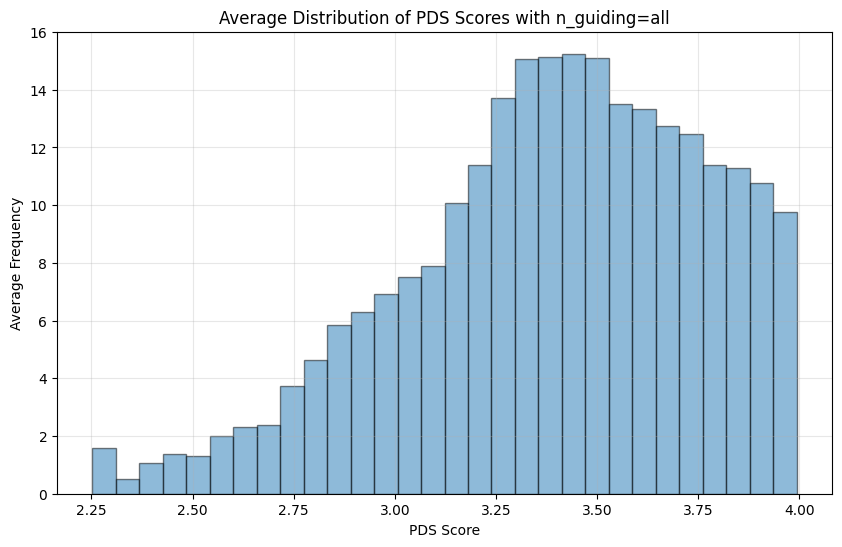

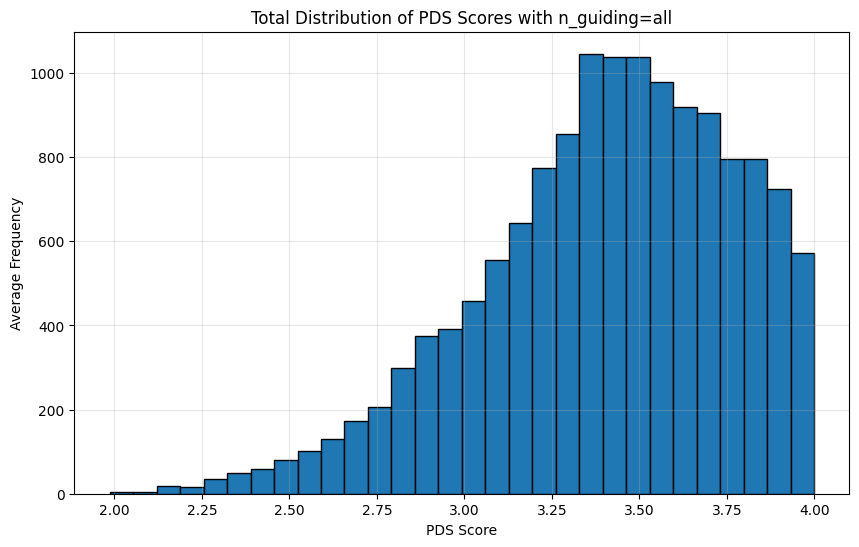

In [24]:
plot_pds_distributions(key='n_guiding=all', pds_scores_folder="disagreement_scores_per_strata")

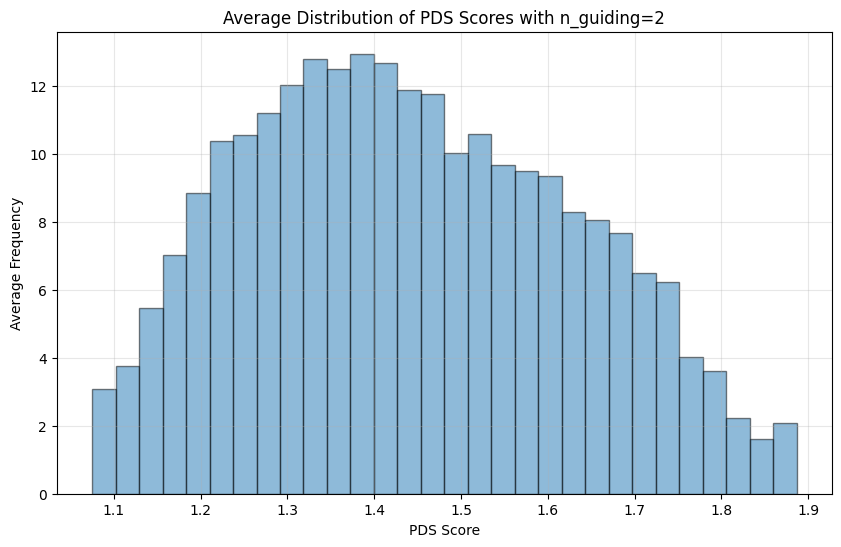

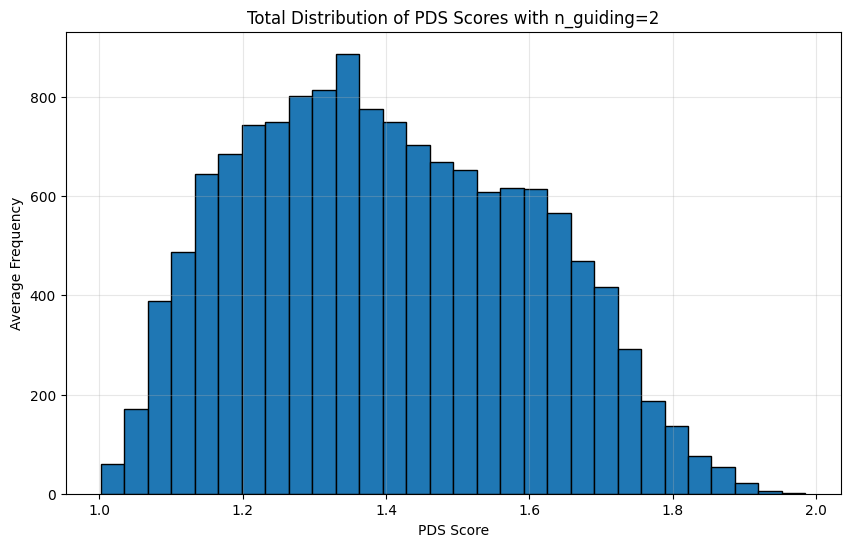

In [25]:
plot_pds_distributions(key='n_guiding=2', pds_scores_folder="disagreement_scores_per_strata")

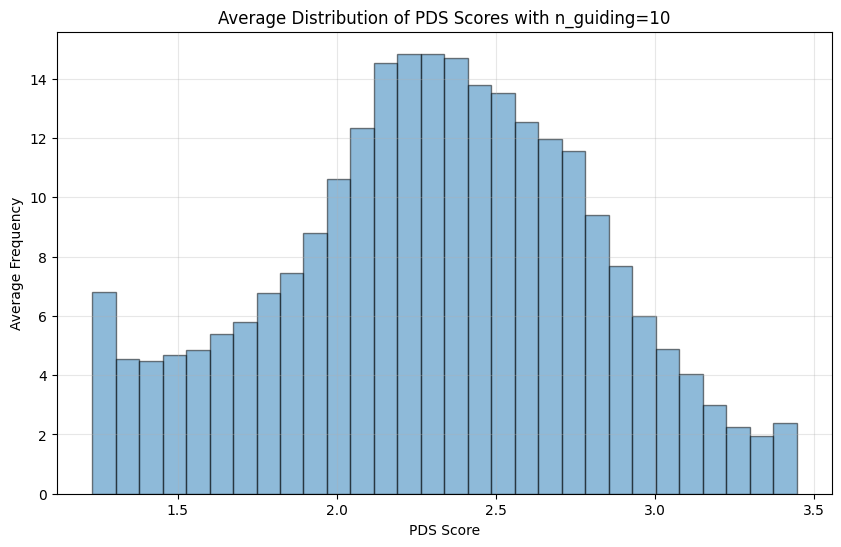

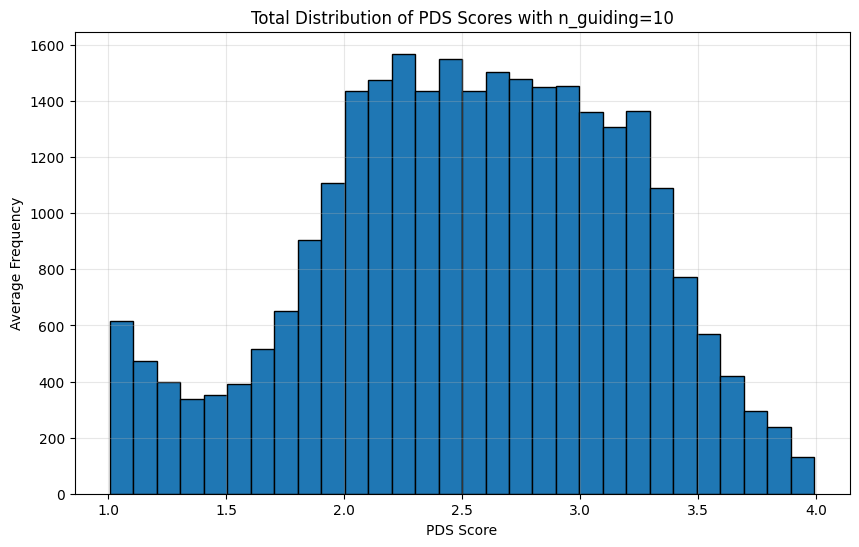

In [26]:
plot_pds_distributions(key='n_guiding=10', pds_scores_folder="disagreement_scores_per_strata")

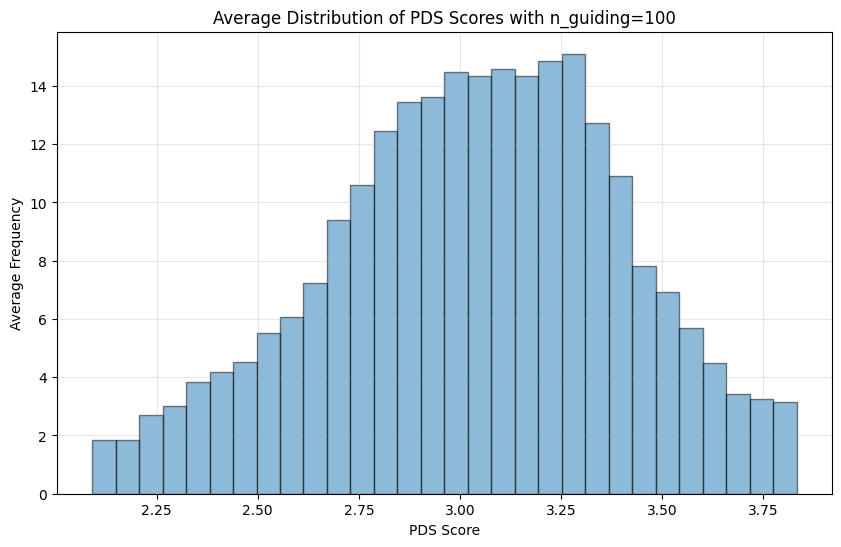

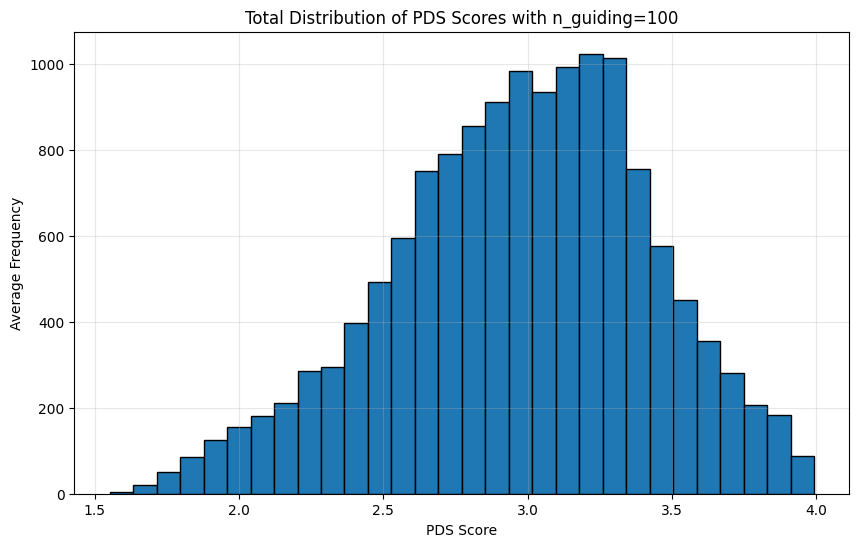

In [27]:
plot_pds_distributions(key='n_guiding=100', pds_scores_folder="disagreement_scores_per_strata")

## About models dates

In [4]:
with open('data/mmlu_fields.pickle', 'rb') as handle:
    data_mmlu_fields = pickle.load(handle)

# with open('data/lb_data.pickle', 'rb') as handle:
#     data_lb = pickle.load(handle)

with open('data/leaderboard_raw_25042025.pickle', 'rb') as handle:
    df_lb_raw = pickle.load(handle)

with open('data/leaderboard_fields_raw_22042025.pickle', 'rb') as handle:
    df_mmlu_fields_raw = pickle.load(handle)

In [67]:
check_order(data_mmlu_fields, df_lb_raw, df_mmlu_fields_raw)

Newest first:
[  3  39  40  43  41  44  42  13  50  49  48  47  46  45  55  54  53  56
  51  57  58  59  52  62  61  66  63  60  65  64  67  68  69  72  73  74
  75  76  77  78  70  71  82  81  80  79  83  89  87  86  85  84  90  91
  88   9  93  92  19  95  96  94  97  17  98  99 100 101 102 104 107 118
 117 116 115 114 113 106 112 111 110 109 108 105 119 103  24   8  23  14
  34  38 127 126 122 128 129 130 131 125 124 123   0 121 120   2 135 141
 140 139 138 137 136 134 133 132  26  32 146 151 152 153 150 149 148 147
 144 145 143 142   1 155 158 157 156 154   7 159 160 161 162 163 167 171
 169 168 170 166 164 165 172 173 174 177 180 179 178 176 175 181 182 183
 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198 199 200 204
  11 207 206 205 201 203 202 213 217 216 215 214 219 211 210 209 208 218
 212 222 221 220 224   4 223 225 227 233   6 228  31 234 235 226 232 231
 230 229 236 237 238 240 239 241 243 242 244 245 246 247 248 249 250 251
 252 253 254 255 256 257 258 259  25 

In [69]:
data_mmlu_fields_ordered = deepcopy(data_mmlu_fields)
data_mmlu_fields_ordered['models'] = [data_mmlu_fields['models'][i] for i in order]
for sub in data_mmlu_fields_ordered['data'].keys():
    # print(sub)
    # if sub in ['harness_arc_challenge_25', 'harness_hellaswag_10', 'harness_truthfulqa_mc_0', 'harness_winogrande_5']:
    #     print(data_mmlu_fields_ordered['data'][sub]['predictions'].shape)
    #     continue
    for key in data_mmlu_fields_ordered['data'][sub].keys():
        # if 'predictions' in data_mmlu_fields_ordered['data'][sub][key].keys():
        #     data_mmlu_fields_ordered['data'][sub][key]['predictions'] = data_mmlu_fields_ordered['data'][sub][key]['predictions'][order]
        print(data_mmlu_fields_ordered['data'][sub][key].shape)
        if key == "correctness":
            data_mmlu_fields_ordered['data'][sub][key] = data_mmlu_fields_ordered['data'][sub][key][:, order]
        else:
            assert key == "predictions"
            data_mmlu_fields_ordered['data'][sub][key] = data_mmlu_fields_ordered['data'][sub][key][:, order, :]
        print(data_mmlu_fields_ordered['data'][sub][key].shape)
dump_pickle(data_mmlu_fields_ordered, 'data/mmlu_fields_ordered.pickle')

(1172, 425)
(1172, 425)
(1172, 425, 31)
(1172, 425, 31)
(10042, 425)
(10042, 425)
(10042, 425, 31)
(10042, 425, 31)
(817, 425)
(817, 425)
(817, 425, 31)
(817, 425, 31)
(1267, 425)
(1267, 425)
(1267, 425, 31)
(1267, 425, 31)
(100, 425)
(100, 425)
(100, 425, 31)
(100, 425, 31)
(135, 425)
(135, 425)
(135, 425, 31)
(135, 425, 31)
(152, 425)
(152, 425)
(152, 425, 31)
(152, 425, 31)
(100, 425)
(100, 425)
(100, 425, 31)
(100, 425, 31)
(265, 425)
(265, 425)
(265, 425, 31)
(265, 425, 31)
(144, 425)
(144, 425)
(144, 425, 31)
(144, 425, 31)
(100, 425)
(100, 425)
(100, 425, 31)
(100, 425, 31)
(100, 425)
(100, 425)
(100, 425, 31)
(100, 425, 31)
(100, 425)
(100, 425)
(100, 425, 31)
(100, 425, 31)
(173, 425)
(173, 425)
(173, 425, 31)
(173, 425, 31)
(102, 425)
(102, 425)
(102, 425, 31)
(102, 425, 31)
(100, 425)
(100, 425)
(100, 425, 31)
(100, 425, 31)
(235, 425)
(235, 425)
(235, 425, 31)
(235, 425, 31)
(114, 425)
(114, 425)
(114, 425, 31)
(114, 425, 31)
(145, 425)
(145, 425)
(145, 425, 31)
(145, 425, 

In [7]:
check_order(load_pickle('data/mmlu_fields_ordered.pickle'), df_lb_raw, df_mmlu_fields_raw, idx=40)

Newest first:
[  0   1   2   3   4   5   6  11  13  12  10   9   8   7  21  29  28  27
  26  25  23  22  24  20  18  17  16  15  14  19  35  41  40  39  38  37
  36  34  33  32  31  30  42  43  44  45  51  55  54  53  52  48  50  49
  47  46  56  57  58  59  60  61  66  68  67  65  64  63  62  80  90  89
  88  87  86  91  85  84  83  82  81  74  79  72  69  78  71  70  73  75
  76  77  98 104 103 102 101 100  99 105  97  95  94  93  92  96 112 117
 116 115 114 113 111 110 109 108 107 106 124 129 128 130 126 125 127 123
 122 121 120 119 118 131 132 133 134 135 136 141 140 139 138 137 142 143
 144 145 146 147 148 149 150 151 152 158 157 156 155 154 153 159 160 161
 162 163 164 165 166 167 170 169 168 171 172 173 174 175 176 177 178 182
 185 184 186 183 181 179 180 192 198 196 195 194 193 197 191 189 188 187
 190 199 200 201 203 204 202 205 211 206 207 208 209 210 212 213 214 215
 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233
 234 235 239 242 241 240 236 238 237 

# Old

Some options

In [16]:
agg = 'leaderboard' # 'leaderboard', 'scenarios'
results = 'acc'# 'acc', 'rank'

In [17]:
# methods = [method for method in methods if method not in ["anchor-irt_gpirt"]]
methods = [method for method in methods]
# methods = cur_methods

In [18]:
methods

['random_naive',
 'anchor_naive',
 'anchor-irt_naive',
 'random_gpirt',
 'anchor_gpirt',
 'anchor-irt_gpirt']

Computing numbers to show in plots

In [21]:
if results == 'acc': ylim = (0,.1)
elif results == 'rank':
    if agg_metric == 'std': ylim = (0,.1)
    else: ylim = (.5,1)
else: raise NotImplementedError

table_avg = {}
table_std = {}
model_perf = {}
for bench in benchs:
    table_avg[bench] = {}
    table_std[bench] = {}
    model_perf[bench] = {}

    for split in splits[bench]:
        table_avg[bench][split] = {}
        table_std[bench][split] = {}
        model_perf[bench][split] = {}


        with open(f'results/accs_{bench}_split-{split}_iterations-5.pickle', 'rb') as handle:
            data = pickle.load(handle)

        models = list(data.keys())
        number_items = list(data[models[0]].keys())
        scenarios = list(data[models[0]][number_items[0]][methods[0]].keys())
        data = np.array([[[[data[model][number_item][method][scenario] for scenario in scenarios]  for model in data.keys()] for number_item in number_items] for method in methods])
        scores = load_scores(bench, split)

        if agg == 'leaderboard':
            if bench=='helm':
                ###
                if results == 'acc':
                    ###
                    model_perf[bench][split]['truth'] = winrate(scores, axis=1).mean(axis=0)
                    for i,method in enumerate(methods):
                        model_perf[bench][split][method] = {}
                        model_perf[bench][split][method] = {}
                        for j,number_item in enumerate(number_items):
                            model_perf[bench][split][method][number_item] = winrate(data, axis=2).mean(axis=3)[i,j,:,:]
                    ###
                    data = np.abs(winrate(data, axis=2).mean(axis=3)-winrate(scores, axis=1).mean(axis=0)[None,None,:,None])
                elif results == 'rank':
                    rank_corrs = np.zeros(data.mean(axis=2).mean(axis=2).shape)
                    #print(bench,rank_corrs.shape)
                    for i in range(rank_corrs.shape[0]):
                        for j in range(rank_corrs.shape[1]):
                            for l in range(rank_corrs.shape[2]):
                                #print(winrate(data, axis=2).mean(axis=3).shape)
                                rank_corrs[i,j,l] = scipy.stats.spearmanr(winrate(data, axis=2).mean(axis=3)[i,j,:,l], winrate(scores.T, axis=0).mean(axis=1)).statistic
                    data=rank_corrs

                else:
                    raise NotImplementedError
            else:
                ###
                if results == 'acc':
                    ###
                    model_perf[bench][split]['truth'] = scores.mean(axis=0)
                    for i,method in enumerate(methods):
                        model_perf[bench][split][method] = {}
                        model_perf[bench][split][method] = {}
                        for j,number_item in enumerate(number_items):
                            model_perf[bench][split][method][number_item] = data.mean(axis=3)[i,j,:,:]
                    ###
                    data = np.abs(data.mean(axis=3)-scores.mean(axis=0)[None,None,:,None])
                elif results == 'rank':
                    rank_corrs = np.zeros(data.mean(axis=2).mean(axis=2).shape)
                    #print(bench,rank_corrs.shape)
                    for i in range(rank_corrs.shape[0]):
                        for j in range(rank_corrs.shape[1]):
                            for l in range(rank_corrs.shape[2]):
                                #print(data.mean(axis=3).shape)
                                rank_corrs[i,j,l] = stats.spearmanr(data.mean(axis=3)[i,j,:,l], scores.T.mean(axis=1)).statistic
                    data=rank_corrs
                else:
                    raise NotImplementedError
        elif agg == 'scenarios':
            if results == 'acc':
                data = np.abs(data-scores.T[None,None,:,:,None]).mean(axis=3)
            elif results == 'rank':
                rank_corrs = np.zeros(data.mean(axis=2).shape)
                for i in range(rank_corrs.shape[0]):
                    for j in range(rank_corrs.shape[1]):
                        for k in range(rank_corrs.shape[2]):
                            for l in range(rank_corrs.shape[3]):
                                rank_corrs[i,j,k,l] = stats.spearmanr(data[i,j,:,k,l], scores.T[:,k]).statistic
                data=rank_corrs
            else:
                raise NotImplementedError
        else:
            raise NotImplementedError

        if agg_metric=='avg':
            data = data.mean(-1) #iterations
        elif agg_metric=='std':
            data = data.std(-1)
        else:
            raise NotImplementedError


        for i,method in enumerate(methods):
            table_avg[bench][split][method] = {}
            table_std[bench][split][method] = {}

            for j,number_item in enumerate(number_items):
                if agg == 'leaderboard' and results == 'rank':
                    #print(data.shape)
                    table_avg[bench][split][method][number_item] = data[i,j]
                    table_std[bench][split][method][number_item] = 0
                else:
                    #print(data.shape)
                    table_avg[bench][split][method][number_item] = np.mean(data, axis=-1)[i,j]
                    table_std[bench][split][method][number_item] = data.std(-1)[i,j]

Sub-scenario harness_gsm8k_5 of scenario gsm8k not found in data2, so skipping it


Sub-scenario harness_gsm8k_5 of scenario gsm8k not found in data2, so skipping it


## Correlation

Plots showing individual performances

In [6]:
model_perf['mmlu_fields']['iid'].keys()

dict_keys(['truth', 'random_naive', 'high-disagreement+nonstratified_naive', 'mean_train_score', 'perfect_knn', 'random_KNN', 'high-disagreement+nonstratified_KNN', 'random_Ridge_10', 'high-disagreement+nonstratified_Ridge_10', 'random_MLP2_e200_lr0.001', 'high-disagreement+nonstratified_MLP2_e200_lr0.001', 'anchor_naive', 'anchor-irt_naive', 'random_pirt', 'anchor_pirt', 'anchor-irt_pirt', 'random_cirt', 'anchor_cirt', 'anchor-irt_cirt', 'random_gpirt', 'anchor_gpirt', 'anchor-irt_gpirt'])

In [ ]:
model_perf['mmlu_fields']['iid'].keys()

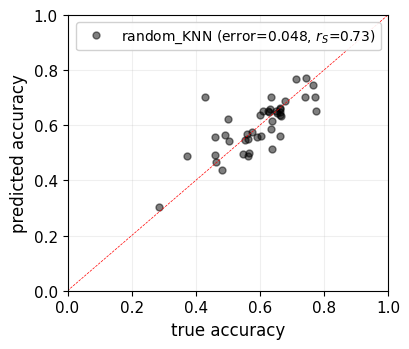

In [17]:
if results == 'acc':
    if agg == 'leaderboard':
        # split = 'noniid'
        split = 'iid'
        iteration = 1
        number_item = 100

        alphas = {'random_naive':.4,'anchor_naive':.4,'anchor-irt_naive':.4,'anchor-irt_gpirt':.8}
        markersize = {'random_naive':7,'anchor_naive':5,'anchor-irt_naive':5,'anchor-irt_gpirt':5}
        names = {'random_naive':'random','anchor-irt_naive':'IRT ','anchor_naive':'correctness','anchor-irt_gpirt':'IRT++'}
        plt.figure(figsize=(1.2*3.5,1.2*3))

        # for i,bench in enumerate(['mmlu']): #benchs[:4]
        for i,bench in enumerate(['mmlu_fields']): #benchs[:4]
            axis = {'lb':'avg. score', 'mmlu_fields':'accuracy', 'mmlu':'accuracy', 'helm':'mean win rate', 'alpaca':'win rate'}
            # for method in ['anchor-irt_gpirt']: #
            for method in ['random_KNN']: #
                # print(model_perf[bench][split][method])
                x,y = model_perf[bench][split]['truth'], model_perf[bench][split][method][number_item][:,iteration]
                method_name = names[method] if method in names else method
                label = "{:} (error={:.3f}, $r_S$={:.2f})".format(method_name, np.abs(x-y).mean(), stats.spearmanr(x,y).statistic)
                markersize = markersize[method] if method in markersize else 5
                alpha = alphas[method] if method in alphas else 0.5
                color = color_mappings[method] if method in color_mappings else 'black'
                plt.plot(x, y, 'o', label = label, markersize=markersize,alpha=alpha, color=color)

            plt.legend(fontsize=10, framealpha=.9)
            #plt.title(titles[bench])
            plt.plot([0,1],[0,1],'--r',lw=.5)
            plt.grid(alpha=.2)
            plt.xlabel('true '+axis[bench], size=12)
            plt.ylabel('predicted '+axis[bench], size=12)
            plt.xlim(0,1)
            plt.ylim(0,1)
            tick_label_size = 11  # Example size, adjust as needed
            plt.tick_params(axis='x', labelsize=tick_label_size)
            plt.tick_params(axis='y', labelsize=tick_label_size)

        plt.tight_layout()
        plt.savefig('plots/mmlu_leaderboard_performance_individual.png', bbox_inches='tight', dpi=400, transparent=True)
        plt.show()

In [ ]:
# old
if results == 'acc':
    if agg == 'leaderboard':
        split = 'noniid'
        iteration = 1
        number_item = 100

        alphas = {'random_naive':.4,'anchor_naive':.4,'anchor-irt_naive':.4,'anchor-irt_gpirt':.8}
        markersize = {'random_naive':7,'anchor_naive':5,'anchor-irt_naive':5,'anchor-irt_gpirt':5}
        names = {'random_naive':'random','anchor-irt_naive':'IRT ','anchor_naive':'correctness','anchor-irt_gpirt':'IRT++'}
        plt.figure(figsize=(1.2*3.5,1.2*3))

        # for i,bench in enumerate(['mmlu']): #benchs[:4]
        for i,bench in enumerate(['mmlu_fields']): #benchs[:4]
            axis = {'lb':'avg. score', 'mmlu':'accuracy', 'helm':'mean win rate', 'alpaca':'win rate'}
            for method in ['anchor-irt_gpirt']: #
            # for method in ['random_KNN']: #
                # print(model_perf[bench][split][method])
                x,y = model_perf[bench][split]['truth'], model_perf[bench][split][method][number_item][:,iteration]
                label = "{:} (error={:.3f}, $r_S$={:.2f})".format(names[method], np.abs(x-y).mean(), stats.spearmanr(x,y).statistic)
                plt.plot(x, y, 'o', label = label, markersize=markersize[method],alpha=alphas[method], color =color_mappings[method])

            plt.legend(fontsize=10, framealpha=.9)
            #plt.title(titles[bench])
            plt.plot([0,1],[0,1],'--r',lw=.5)
            plt.grid(alpha=.2)
            plt.xlabel('true '+axis[bench], size=12)
            plt.ylabel('predicted '+axis[bench], size=12)
            plt.xlim(0,1)
            plt.ylim(0,1)
            tick_label_size = 11  # Example size, adjust as needed
            plt.tick_params(axis='x', labelsize=tick_label_size)
            plt.tick_params(axis='y', labelsize=tick_label_size)

        plt.tight_layout()
        plt.savefig('plots/mmlu_leaderboard_performance_individual.png', bbox_inches='tight', dpi=400, transparent=True)
        plt.show()

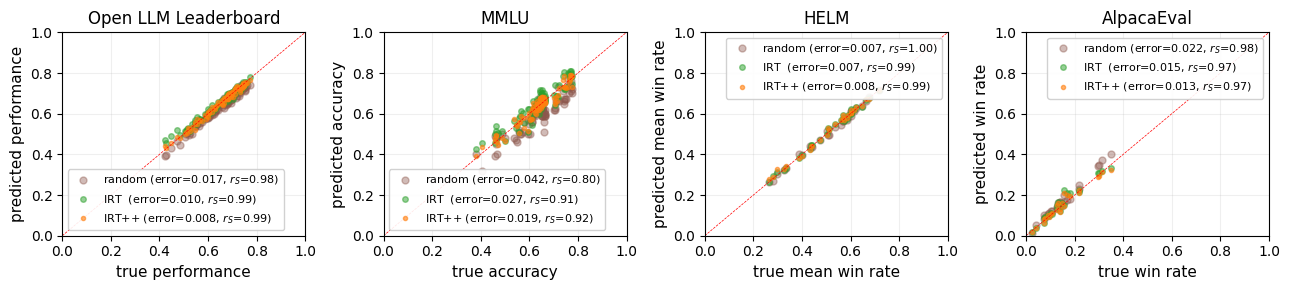

In [6]:
if results == 'acc':
    if agg == 'leaderboard':
        split = 'noniid'
        iteration = 1
        number_item = 100

        alphas = {'random_naive':.4,'anchor_naive':.5,'anchor-irt_naive':.5,'anchor-irt_gpirt':.6}
        markersize = {'random_naive':5,'anchor_naive':4,'anchor-irt_naive':4,'anchor-irt_gpirt':3}
        names = {'random_naive':'random','anchor-irt_naive':'IRT ','anchor_naive':'correct.','anchor-irt_gpirt':'IRT++'}
        plt.figure(figsize=(13,3))

        for i,bench in enumerate(benchs[:4]): #benchs[:4]
            plt.subplot(1, 4, i+1)
            axis = {'lb':'performance', 'mmlu':'accuracy', 'helm_lite':'mean win rate', 'alpaca':'win rate'}
            for method in ['random_naive','anchor-irt_naive','anchor-irt_gpirt']: #

                x,y = model_perf[bench][split]['truth'], model_perf[bench][split][method][number_item][:,iteration]
                label = "{:} (error={:.3f}, $r_S$={:.2f})".format(names[method], np.abs(x-y).mean(), stats.spearmanr(x,y).statistic)
                plt.plot(x, y, 'o', label = label, markersize=markersize[method],alpha=alphas[method], color =color_mappings[method])

            plt.legend(fontsize=8, framealpha=.9)
            plt.title(titles[bench])
            plt.plot([0,1],[0,1],'--r',lw=.5)
            plt.grid(alpha=.2)
            plt.xlabel('true '+axis[bench], size=11)
            plt.ylabel('predicted '+axis[bench], size=11)
            plt.xlim(0,1)
            plt.ylim(0,1)
            tick_label_size = 10  # Example size, adjust as needed
            plt.tick_params(axis='x', labelsize=tick_label_size)
            plt.tick_params(axis='y', labelsize=tick_label_size)

        plt.tight_layout()
        plt.savefig('plots/leaderboard_performance_individual.png', bbox_inches='tight', dpi=400, transparent=True)
        plt.show()

Plots for aggregated performances

In [5]:
style = {"alpha":1, "markersize":3, "markeredgewidth":1, "elinewidth":1, "capsize":3, "linestyle":''}

def plot_perf_lines(table_avg, table_std, methods, title, xlabel, ylabel, ylim,
                    legend=False, error_bar=False, show_title=True, show_xlabel=True, show_ylabel=True, ncols=6, posic=(-1.5, -.35)):

    markers = ['o', 'v', '*', 'x', 's','p']
    jitters = [-6.3,-3.7,-1.3,1.3,3.7,6.3]
    colors = matplotlib.rcParams['axes.prop_cycle'].by_key()['color'][:9]
    j=0
    # for method, values in table_avg.items():

    for method in methods:
        values = table_avg[method]
        x = np.array(list(values.keys()))
        y = np.array(list(values.values()))
        s = np.array(list(table_std[method].values()))

        if error_bar:
            plt.errorbar(x+jitters[j], y, color =color_mappings[method], yerr=s, label=rename_mappings[method], marker=markers[j], **style)
        else:
            plt.plot(x, y, label=method)

        j+=1
    if show_xlabel: plt.xlabel(xlabel, size=11)
    if show_ylabel: plt.ylabel(ylabel, size=11)
    plt.ylim(ylim[0], ylim[1])
    if show_title:
        plt.title(title)
    else:
        pass

    tick_label_size = 10  # Example size, adjust as needed
    plt.tick_params(axis='x', labelsize=tick_label_size)
    plt.tick_params(axis='y', labelsize=tick_label_size)

    if legend: plt.legend(loc='upper center', ncols=ncols, bbox_to_anchor=posic)
    plt.grid(alpha=.2)
    #plt.grid(which='major', color='black', linestyle='-')
    #plt.grid(which='minor', color='gray', linestyle=':')
    #plt.show()


KeyError: 'mean_train_score'

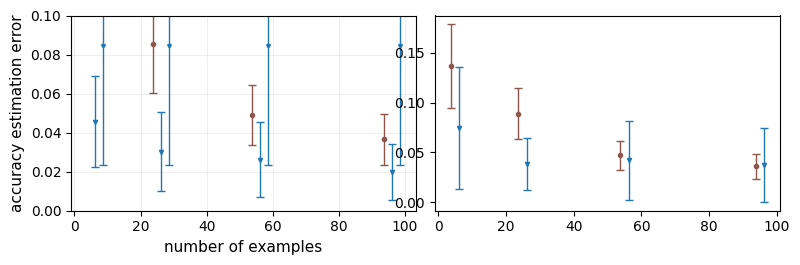

In [6]:
plt.figure(figsize=(8,2.75))
bench='mmlu_fields'
methods = table_avg["mmlu_fields"]["iid"].keys()
methods = [method for method in methods if method not in ['random_pirt', 'anchor_pirt', 'random_cirt', 'anchor_cirt', "anchor-irt_cirt", "anchor-irt_pirt"]]
# Iterate over your benchmarks
for i, split in enumerate(splits[bench]):  # Replace `benchmarks` with your list of benchmarks
    # Plot on the ith subplot
    plt.subplot(1, 2, i+1)
    if results == 'rank': ylabel='Spearman correlation \nfor LLMs ranking'
    else: ylabel='accuracy estimation error'

    plot_perf_lines(table_avg[bench][split], table_std[bench][split],
                    methods=methods,
                    title='',
                    xlabel='number of examples',
                    ylabel=ylabel, ylim=ylim, legend=i==1, error_bar=True, show_ylabel=split=='iid', ncols=1, posic=(1.35, .9))
    plt.tight_layout()
plt.savefig(f'plots/mmlu_performance_specialized_models_{results}.png', bbox_inches='tight', dpi=400, transparent=True)
plt.show()

In [9]:
table_avg["mmlu_fields"]["iid"]

{'random_naive': {10: np.float64(0.13935304685698444),
  30: np.float64(0.0855855279553822),
  60: np.float64(0.04906082878273974),
  100: np.float64(0.03668795130641365)},
 'anchor_naive': {10: np.float64(0.045623093233044365),
  30: np.float64(0.0302330769287558),
  60: np.float64(0.026046859349143605),
  100: np.float64(0.019974932715334223)},
 'anchor-irt_naive': {10: np.float64(0.09677511892941068),
  30: np.float64(0.05602713063756833),
  60: np.float64(0.05102997411596358),
  100: np.float64(0.036205907942172565)},
 'random_gpirt': {10: np.float64(0.0672271688044593),
  30: np.float64(0.050318702486261135),
  60: np.float64(0.030613619049713197),
  100: np.float64(0.024705793716240126)},
 'anchor_gpirt': {10: np.float64(0.039637234371132056),
  30: np.float64(0.02762700261699875),
  60: np.float64(0.02167682301795958),
  100: np.float64(0.018189036987537315)},
 'anchor-irt_gpirt': {10: np.float64(0.0575200790583067),
  30: np.float64(0.03925709798072776),
  60: np.float64(0.0383

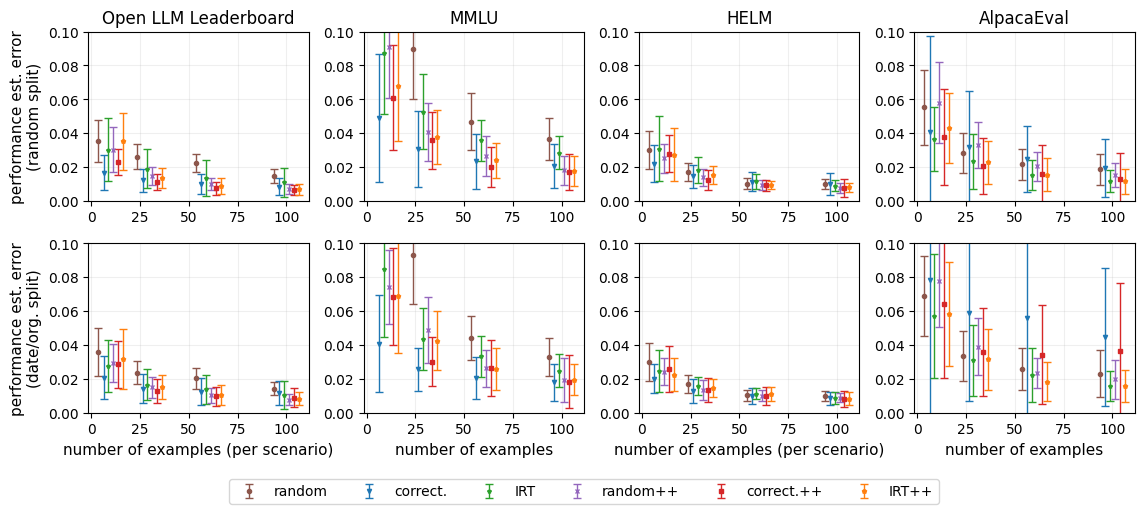

In [ ]:
if agg == 'leaderboard':
    plt.figure(figsize=(.9*15,.9*5.5))
    plt.subplots_adjust(wspace=.25, hspace=.25)

    for j, split in enumerate(splits[bench]):
        ylabel_dic = {'iid':'(random split)', 'noniid':'(date/org. split)'}
        if results == 'rank': ylabel=f'Spearman correlation \n for LLMs ranking\n{ylabel_dic[split]}'
        else: ylabel = f'performance est. error\n{ylabel_dic[split]}'

        # Iterate over your benchmarks
        for i, bench in enumerate(benchs[:4]):  # Replace `benchmarks` with your list of benchmarks
            if bench in ['mmlu','alpaca']: xlabel='number of examples'
            else: xlabel='number of examples (per scenario)'
            # Plot on the ith subplot
            plt.subplot(2, 4, 4*j + i+1)
            plot_perf_lines(table_avg[bench][split], table_std[bench][split],
                            title=titles[bench],
                            xlabel=xlabel,
                            ylabel=ylabel, ylim=ylim, legend=((i+1==4) and split=='noniid'),
                            error_bar=True,show_title=split=='iid', show_xlabel=split=='noniid', show_ylabel=bench=='lb')#ylims[bench]

        #plt.suptitle(split)
        # Adjust layout
        #plt.tight_layout()

        # Display the plot
    plt.savefig(f'plots/leaderboard_performance_{results}.png', bbox_inches='tight', dpi=400, transparent=True)
    plt.show()

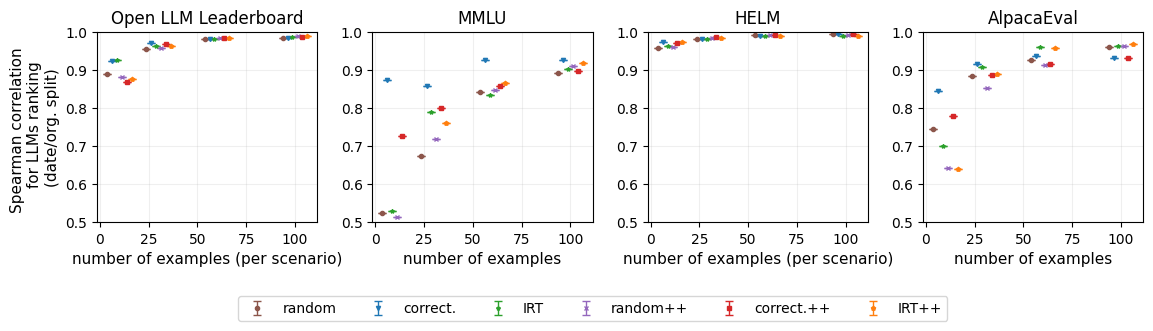

In [9]:
# Same plot as above
if agg == 'leaderboard':
    plt.figure(figsize=(.9*15,.9*5.5/2))
    plt.subplots_adjust(wspace=.25, hspace=.25)

    for j, split in enumerate(['noniid']):
        ylabel_dic = {'iid':'(random split)', 'noniid':'(date/org. split)'}
        if results == 'rank': ylabel=f'Spearman correlation \n for LLMs ranking\n{ylabel_dic[split]}'
        else: ylabel = f'performance est. error\n{ylabel_dic[split]}'

        # Iterate over your benchmarks
        for i, bench in enumerate(benchs[:4]):  # Replace `benchmarks` with your list of benchmarks
            if bench in ['mmlu','alpaca']: xlabel='number of examples'
            else: xlabel='number of examples (per scenario)'
            # Plot on the ith subplot
            plt.subplot(1, 4, 4*j + i+1)
            plot_perf_lines(table_avg[bench][split], table_std[bench][split],
                            title=titles[bench],
                            xlabel=xlabel,
                            ylabel=ylabel, ylim=ylim, legend=((i+1==4) and split=='noniid'),
                            error_bar=True,show_title=split=='noniid', show_xlabel=split=='noniid', show_ylabel=bench=='lb')#ylims[bench]

        #plt.suptitle(split)
        # Adjust layout
        #plt.tight_layout()

        # Display the plot
    plt.savefig(f'plots/leaderboard_performance_{results}_noniid.png', bbox_inches='tight', dpi=400, transparent=True)
    plt.show()

In [10]:
if agg == 'scenarios':
    plt.figure(figsize=(.5*.9*15,.9*5.5))
    plt.subplots_adjust(wspace=.25, hspace=.25)

    for j, split in enumerate(splits[bench]):
        # Create a figure and a set of subplots


        ylabel_dic = {'iid':'(random split)', 'noniid':'(date/org. split)'}

        if results == 'rank': ylabel=f'avg. scenarios Spearman\n  corr. for LLMs ranking\n{ylabel_dic[split]}'
        else: ylabel = f'avg. scenarios\n performance est. error\n{ylabel_dic[split]}'

        # Iterate over your benchmarks
        for i, bench in enumerate(['lb','helm_lite']):  # Replace `benchmarks` with your list of benchmarks
            if bench in ['mmlu','alpaca']: xlabel='number of examples'
            else: xlabel='number of examples (per scenario)'
            # Plot on the ith subplot
            plt.subplot(2, 2, 2*j +i+1)
            plot_perf_lines(table_avg[bench][split], table_std[bench][split],
                            title=titles[bench],
                            xlabel=xlabel,
                            ylabel=ylabel, ylim=ylim, legend=(j==1 and i==1),error_bar=True,
                            show_title=split=='iid', show_xlabel=split=='noniid', show_ylabel=bench=='lb', posic=(-.2, -.35))

        #plt.suptitle(split)
        # Adjust layout
        #plt.tight_layout()

        # Display the plot
    plt.savefig(f'plots/avg_scenarios_performance_{results}.png', bbox_inches='tight', dpi=400, transparent=True)
    plt.show()

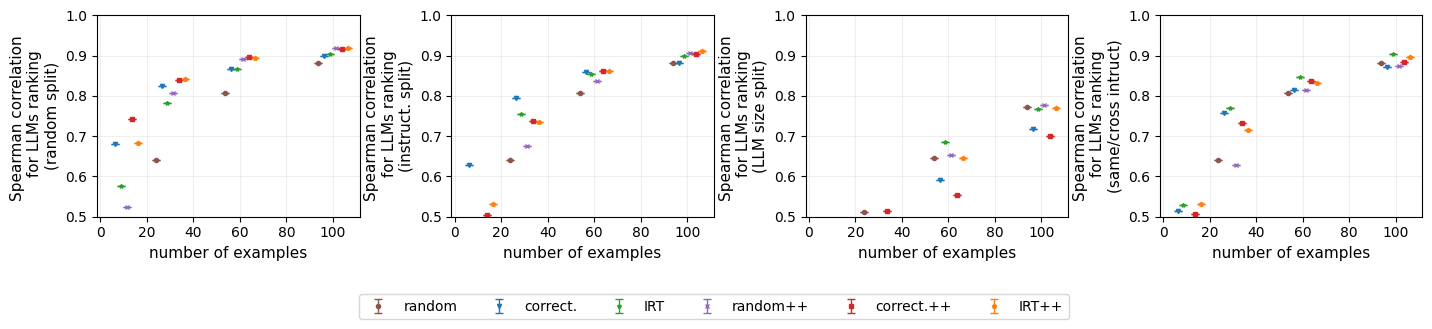

In [11]:
if agg == 'leaderboard':
    plt.figure(figsize=(.95*18,.95*5.5/2))
    plt.subplots_adjust(wspace=.35, hspace=.25)

    for j, split in enumerate(splits['icl_templates']):
        ylabel_dic = {'iid':'(random split)', 'noniid':'(instruct. split)', 'noniid2':'(LLM size split)', 'noniid3':'(same/cross intruct)'}
        if results == 'rank': ylabel=f'Spearman correlation \n for LLMs ranking\n{ylabel_dic[split]}'
        else: ylabel = f'performance est. error\n{ylabel_dic[split]}'

        # Iterate over your benchmarks
        for i, bench in enumerate(['icl_templates']):  # Replace `benchmarks` with your list of benchmarks
            xlabel='number of examples'
            # Plot on the ith subplot
            plt.subplot(1, 4, j + i+1)
            plot_perf_lines(table_avg[bench][split], table_std[bench][split],
                            title=titles[bench],
                            xlabel=xlabel,
                            ylabel=ylabel, ylim=ylim, legend=(split=='noniid'),
                            error_bar=True,show_title=False, show_xlabel=True, show_ylabel=True,
                            posic=(1, -.35))#ylims[bench]

        #plt.suptitle(split)
        # Adjust layout
        #plt.tight_layout()

        # Display the plot
    plt.savefig(f'plots/icl_templates_{results}.png', bbox_inches='tight', dpi=400, transparent=False)
    plt.show()